## Load Libs

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import torch 
import torchvision
from PIL import Image
import json
import datetime

## Check out metadata

In [4]:
data_dir = '/home/misha/downloads/roofnet/data'
df = pd.read_csv(data_dir + '/roofdata_small/export_source_LA_Reroof_dataset.csv') 
df.head()

,id,street_number,route,city,state,zip_code,site_address,google_place_id,latitude,longitude,...,person_3_email,person_3_phone_number,person_3_company_name,person_3_company_address,person_4_name,person_4_role,person_4_email,person_4_phone_number,person_4_company_name,person_4_company_address
0,33136,19780,Pacific Gateway Dr,Torrance,CA,90502,"19780 Pacific Gateway Dr, Torrance, CA 90502, USA",ChIJV_-baavKwoAR1pYHD_Ypvyk,33.851577,-118.294618,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,37420,9301,Mason Ave,Los Angeles,CA,91311,"9301 Mason Ave, Chatsworth, CA 91311, USA",ChIJ8SY3aJ2cwoARbTnakzU-sTk,34.240311,-118.580710,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,36810,550,S Mission Rd,Los Angeles,CA,90033,"550 S Mission Rd, Los Angeles, CA 90033, USA",ChIJLZoUqxnGwoARfFX6OInOiEQ,34.039320,-118.226157,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,36162,21001,Nordhoff St,Los Angeles,CA,91311,"21001 Nordhoff St, Chatsworth, CA 91311, USA",ChIJ3dCw_4-cwoAR9YoJKWp7itU,34.235802,-118.591260,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,30811,13000,Pierce St,Los Angeles,CA,91331,"13000 Pierce St, Pacoima, CA 91331, USA",ChIJu18zUHORwoARR-vcmdFBxFs,34.264688,-118.415671,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Preprocess images from folder to numpy object

In [5]:
import os
img_dir = data_dir + '/roofdata_small/tour_images/'

imgs = {}
def read_image_pil(path):
    img = Image.open(path)
    o_img = img.copy()
    img.thumbnail((64, 64), Image.ANTIALIAS)
    img = np.array(img)[:32,:]
    # take rgb instead of rgba
    img = img[:,:,:3]
    return o_img,img
        
for subdir, dirs, _ in os.walk(img_dir):
    for d in dirs:
        path = subdir + d + '/'
        metajson = path+'metadata.json'
        with open(metajson) as f:
            meta = json.load(f)
            issue = meta['reroof_permit_issue_date']
            expiration = meta['reroof_permit_expiration_date']
            address = meta['address']
            key = hash(address)
        imgs[address]={'imgs':[],'years':[],'issue':[],'expiration':[],'address':[]}
        print('address',address)
        for _, _, files in os.walk(path):
            for i,file in enumerate(files):
                if 'png' in file:
                    print('loading',i,file)

                    _,img = read_image_pil(path + file)
                    imgs[address]['years'].append(int(file[:-4]))
                    imgs[address]['imgs'].append(img)
                    imgs[address]['issue']=issue
                    imgs[address]['expiration'] = expiration
                    imgs[address]['address'] = address
            
    if '' in imgs:
        del imgs['']


address 20730 Dearborn St, Chatsworth, CA 91311, USA
loading 0 2012.png
loading 2 2017.png
loading 3 2018.png
loading 4 2016.png
loading 5 2014.png
loading 6 2015.png
loading 7 2013.png
address 7333 Radford Ave, North Hollywood, CA 91605, USA
loading 0 2012.png
loading 2 2017.png
loading 3 2018.png
loading 4 2016.png
loading 5 2014.png
loading 6 2015.png
loading 7 2013.png
address 13315 S Figueroa St, Los Angeles, CA 90061, USA
loading 0 2012.png
loading 2 2017.png
loading 3 2018.png
loading 4 2016.png
loading 5 2014.png
loading 6 2015.png
loading 7 2013.png
address 550 S Mission Rd, Los Angeles, CA 90033, USA
loading 0 2012.png
loading 2 2017.png
loading 3 2018.png
loading 4 2016.png
loading 5 2014.png
loading 6 2015.png
loading 7 2013.png
address 9330 De Soto Ave, Chatsworth, CA 91311, USA
loading 0 2012.png
loading 2 2017.png
loading 3 2018.png
loading 4 2016.png
loading 5 2014.png
loading 6 2015.png
loading 7 2013.png
address 12458 Gladstone Ave, Sylmar, CA 91342, USA
loading 0 201

## Save and load

In [6]:
imgs = {'data':imgs}
np.save(data_dir + 'small_dataset.npy',imgs)

In [7]:
dataset = np.load(data_dir + 'small_dataset.npy',allow_pickle=True)
dataset = dataset.item().get('data')

In [8]:
from roofnet.utils.data import ImageDataset, TripletBuildingSampler
from torchvision.transforms import transforms 

data_file_path = '/home/misha/downloads/roofnet/data/small_dataset.npy'
data = ImageDataset(data_file_path, 
                    transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(
                                    (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                            ]))


Loading data
Done loading data


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


img shape: [3, 32, 64] 
img year: 2012 
transition year: 2017 
address: 550 S Mission Rd, Los Angeles, CA 90033, USA
img shape: [3, 32, 64] 
img year: 2016 
transition year: 2017 
address: 550 S Mission Rd, Los Angeles, CA 90033, USA
img shape: [3, 32, 64] 
img year: 2018 
transition year: 2017 
address: 550 S Mission Rd, Los Angeles, CA 90033, USA


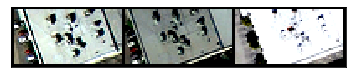

In [18]:
from datetime import datetime
from torchvision.utils import make_grid

sampler = TripletBuildingSampler(data,batch_size=1)
loader = torch.utils.data.DataLoader(data, sampler=sampler,batch_size=3)

x,y,meta = next(iter(loader))
start,end = 0,3
for i in range(len(y)):
    print('='*20)
    print('img shape:',[n for n in x[i].shape],'\nimg year:',y[i].item(),'\ntransition year:',meta['transition_year'][i].item(),'\naddress:',meta['address'][i])

    
def display_image_grid(x,nrow=8):
    x = make_grid(x.cpu().detach()+0.5,nrow=nrow)
    x = x.numpy()
    fig = plt.imshow(np.transpose(x, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    
    
display_image_grid(x[start:end,:,:,:],nrow=3)
